In [5]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

In [6]:
data = sm.datasets.co2.load_pandas()
y = data.data
y = y['co2'].resample('MS').mean()
y = y.fillna(y.bfill())
y

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

In [14]:
train = y[:'1997-12-01']
test = y['1998-01-01':]

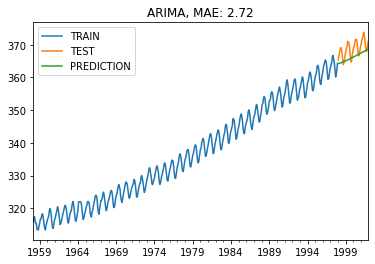

In [15]:
arima_model = ARIMA(train, order=(1, 1, 1)).fit(disp=0)

arima_model.summary()

y_pred = arima_model.forecast(48)[0]
y_pred = pd.Series(y_pred, index=test.index)

def plot_co2(train, test, y_pred, title):
    """
    Plots training data (from 1951 onwards), test data, and ARIMA model predictions,
    and displays the Mean Absolute Error (MAE) in the plot title.

    Parameters:
    -----------
    train : pandas.Series or pandas.DataFrame
        Training dataset used to fit the model.

    test : pandas.Series or pandas.DataFrame
        Actual values used for evaluating the model predictions.

    y_pred : pandas.Series or numpy.ndarray
        Predicted values obtained from the ARIMA model.

    title : str
        Title displayed on the plot.

    Returns:
    --------
    None
        Displays the resulting plot.

    Example:
    --------
    plot_co2(train, test, y_pred, "ARIMA")
    """
    mae = mean_absolute_error(test, y_pred)
    train["1951":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

plot_co2(train, test, y_pred, "ARIMA")


In [16]:
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))


def arima_optimizer_aic(train, orders):
    """
    Iterates over a given set of ARIMA hyperparameter combinations (orders),
    fits each ARIMA model to the training data, and identifies the best combination
    of parameters based on the lowest Akaike Information Criterion (AIC).

    Parameters:
    -----------
    train : pandas.Series or array-like
        Time series data used for fitting the ARIMA models.

    orders : list or iterable of tuples
        A list of ARIMA hyperparameter combinations to evaluate.
        Each tuple must be in the format (p, d, q).

    Returns:
    --------
    best_params : tuple
        The ARIMA hyperparameters (p, d, q) corresponding to the lowest AIC.

    Prints:
    -------
    - The AIC for each ARIMA model evaluated.
    - The best ARIMA model parameters along with the lowest AIC.

    Example:
    --------
    orders = [(1,1,1), (2,1,2), (3,1,0)]
    best_params = arima_optimizer_aic(train, orders)
    """
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order).fit(disp=0)
            aic = arima_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params
best_params_aic = arima_optimizer_aic(train, pdq)


ARIMA(0, 0, 0) AIC=3954.01
ARIMA(0, 0, 1) AIC=3312.73
ARIMA(0, 1, 0) AIC=1522.49
ARIMA(0, 1, 1) AIC=1254.44
ARIMA(0, 1, 2) AIC=1138.37
ARIMA(0, 1, 3) AIC=1095.43
ARIMA(0, 2, 0) AIC=1281.81
ARIMA(0, 2, 1) AIC=1259.89
ARIMA(0, 2, 2) AIC=1249.75
ARIMA(0, 2, 3) AIC=1143.43
ARIMA(1, 0, 0) AIC=1536.59
ARIMA(1, 0, 1) AIC=1267.22
ARIMA(1, 0, 2) AIC=1149.97
ARIMA(1, 0, 3) AIC=1105.72
ARIMA(1, 1, 0) AIC=1209.00
ARIMA(1, 1, 1) AIC=1503.17
ARIMA(1, 2, 0) AIC=1258.05
ARIMA(2, 0, 0) AIC=1217.86
ARIMA(2, 0, 1) AIC=1168.37
ARIMA(2, 0, 2) AIC=1266.15
ARIMA(2, 1, 0) AIC=1103.80
ARIMA(2, 1, 2) AIC=855.34
ARIMA(2, 1, 3) AIC=800.75
ARIMA(2, 2, 0) AIC=1259.14
ARIMA(3, 0, 0) AIC=1115.61
ARIMA(3, 0, 2) AIC=1069.77
ARIMA(3, 1, 0) AIC=1048.84
ARIMA(3, 2, 0) AIC=1211.68
Best ARIMA(2, 1, 3) AIC=800.75


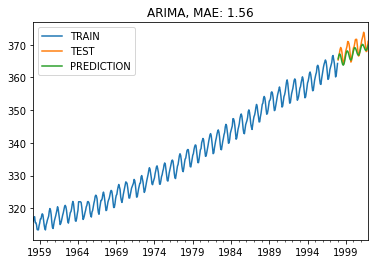

In [17]:
arima_model = ARIMA(train, best_params_aic).fit(disp=0)
y_pred = arima_model.forecast(48)[0]

y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "ARIMA")

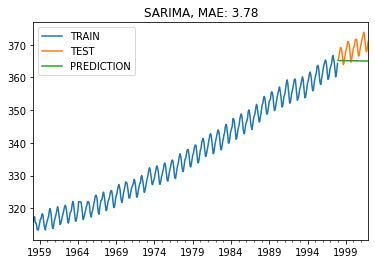

In [18]:
model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(0, 0, 0, 12))

sarima_model = model.fit(disp=0)

y_pred_test = sarima_model.get_forecast(steps=48)

y_pred = y_pred_test.predicted_mean
    
y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "SARIMA")

In [20]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [21]:
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    """
    Finds the best SARIMA model parameters based on the lowest Akaike Information Criterion (AIC).
    Iterates over combinations of non-seasonal (pdq) and seasonal (seasonal_pdq) parameters,
    fits SARIMA models, and selects the optimal combination.

    Parameters:
    -----------
    train : pandas.Series or array-like
        Training time series data to fit the SARIMA models.

    pdq : list of tuples
        List of non-seasonal ARIMA parameter combinations (p, d, q) to evaluate.

    seasonal_pdq : list of tuples
        List of seasonal ARIMA parameter combinations (P, D, Q, s) to evaluate,
        typically with s=12 for monthly data.

    Returns:
    --------
    best_order : tuple
        Optimal non-seasonal ARIMA parameters (p, d, q) corresponding to the lowest AIC.

    best_seasonal_order : tuple
        Optimal seasonal ARIMA parameters (P, D, Q, s) corresponding to the lowest AIC.

    Prints:
    -------
    - AIC for each SARIMA model evaluated.
    - Best SARIMA parameters and the associated lowest AIC.

    Example:
    --------
    pdq = [(1,1,1), (2,1,2)]
    seasonal_pdq = [(0,1,1,12), (1,1,0,12)]
    best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)
    """
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order

best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6922.606550808509
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6318.305219680292
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1643.999665788036
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1428.2938925362027
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1872.7150224716324
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1642.9372992270748
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1205.025400970746
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:973.2077279534776
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6269.190364741235
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5663.567927987491
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1229.8447515358193
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1126.5843176967883
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1477.526611492002
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2030.5697386637537
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1008.1602685141655
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:767.6332842978167
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1523.9134546906607
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:11

In [22]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

In [23]:

y_pred_test = sarima_final_model.get_forecast(steps=48)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

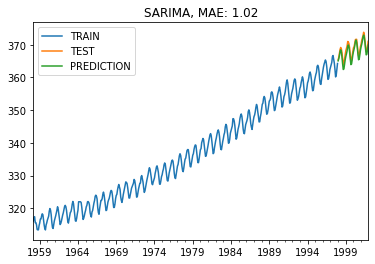

In [24]:
plot_co2(train, test, y_pred, "SARIMA")

In [25]:
model = SARIMAX(y, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

In [26]:
feature_predict = sarima_final_model.get_forecast(steps=6)
feature_predict = feature_predict.predicted_mean